# Chap06 - Decision Tree

**Desicion Tree**(이하, 결정 트리 또는 의사결정나무)는 **분류**와 **회귀**에 사용할 수 있는 머신러닝 알고리즘이다. 

이번 장에서는 결정 트리의 훈련, 시각화, 예측 방법에 대해 알아보고, 결정 트리 중 Scikit-Learn의 CART 알고리즘을 알아보고 트리에 규제를 적용하는 방법과 회귀 문제에 적용하는 방법에 대해 알아 보도록 하자.

## Set Up

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 6.1 결정 트리 학습과 시각화

다음 예제는 붓꽃(iris) 데이터셋을 Scikit-Learn의 [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)를 이용해 학습시키는 코드이다.

> Scikit-Learn은 **이진 트리**만 만드는 **CART** 알고리즘을 사용하기 때문에, 리프 노드를 제외한 모든 노드는 자식노드를 2개씩 가진다(조건에 대해, 'yes' or 'no'). 하지만, **ID3** 알고리즘을 이용해 2개 이상의 자식 노드를 가지는 결정트리를 만들 수 있다.  

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                out_file='./images/iris_tree.dot', 
                feature_names=["꽃잎 길이 (cm)", "꽃잎 너비 (cm)"], 
                class_names=iris.target_names, 
                rounded=True, 
                filled=True)

In [4]:
# !conda install python-graphviz  # Windows

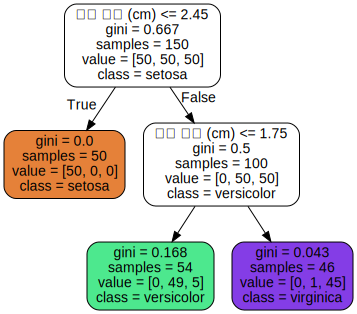

In [5]:
import graphviz

with open("./images/iris_tree.dot", encoding='UTF8') as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='./images', cleanup=True)
dot

위의 그래프에서 노드의 각 속성에 대한 설명은 다음과 같다.

- `sample` : 각 노드로 분류된 데이터의 개수를 말한다.
- `value` : 각 노드에서 label(여기서는 `setosa, versicolor, virginica`)에 속하는 데이터의 개수를 말한다.
    - 예를 들어, 왼쪽 주황색 노드는 `setosa`가 50개, `versicolor, virginica`는 0개를 의미한다.

- `gini` : **불순도**(impurity)를 의미하며, 불순도를 측정하는 지표인 **지니(gini)** 계수를 이용한다.
    - 예를 들어, level 2의 초록색 노드의 gini 계수는 $1-(\frac{0}{54})^{2} - (\frac{49}{54})^{2} - (\frac{5}{54})^{2} \approx 0.168$ 이다. 

- Gini 계수의 수식은 다음과 같다.

$$
G_i = 1 - \sum_{k=1}^{n}{p_{i,k}^{2}}
$$

- $p_{i, k}$ 는 $i$번째 노드에 있는 데이터 중 클래스 $k$에 속한 샘플의 비율이다.

## 6.2 예측하기

Decision Tree를 이용한 분류기가 어떻게 붓꽃의 종류를 예측하는지에 대해 위의 그래프(graphviz)를 통해 알아보자. 

1. 맨위의 노드인 **루트 노드**(root node)에서 꽃잎의 길이(petal length)가 `2.45cm`보다 짧은지 비교한다.
2. `2.45cm`보다 짧다면 왼쪽 노드(주황색)인 **자식 노드**(child node)로 이동한다.
    - 이 경우에는 더 이상의 자식 노드가 없으므로 **리프 노드**(leaf node)가 된다.
    - 그리고, 꽃의 종류를 `setosa`라고 예측한다.
3. 반대로, `2.45cm` 보다 긴 경우 오른쪽 자식 노드로 가며, 꽃잎 너비가 `1.75cm` 보다 짧은지 비교하게 된다. 
4. 꽃잎의 너비가 `1.75cm` 보다 짧으면 왼쪽 리프 노드(초록색)로 가게되며, `versicolor`라고 예측하며, `1.75cm` 보다 길면, 오른쪽 리프 노드(보라색)으로 가게되며, `virginica`로 예측한다. 

> Decision Tree 의 장점은 데이터 전처리가 거의 필요하지 않다는 것이며, 특히 특성(feature)의 스케일을 맞추거나 평균을 원점에 맞추는 작업(`StandardScaler`)이 필요하지 않다.

아래의 예제는 위의 결정 트리에 대한 결정 경계(decision boundary)를 보여준다. 

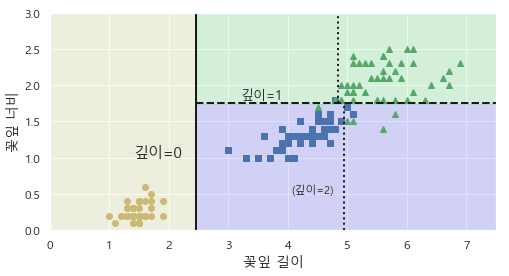

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("꽃잎 길이", fontsize=14)
        plt.ylabel("꽃잎 너비", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "깊이=0", fontsize=15)
plt.text(3.2, 1.80, "깊이=1", fontsize=13)
plt.text(4.05, 0.5, "(깊이=2)", fontsize=11)

plt.show()

#### 화이트박스 vs 블랙박스

위에서 확인할 수 있듯이, 결정 트리 모델은 매우 직관적이며, 모델의 예측 즉, 결정 방식을 이해하기 쉽다. 이러한 모델을 **화이트박스**(white box) 모델이라고 한다. 반대로, 추후에 다룰 랜덤포레스트나 신경망은 이러한 결정 방식을 이해하기에는 어렵기 때문에 **블랙박스**(black box)모델이라 한다.

## 6.3 클래스 확률 추정

결정 트리는 어떤 하나의 데이터(샘플)이 특정 클래스 $k$에 분류될 확률을 추정(계산)할 수 있다. 확률을 추정하는 방법은 각 리프 노드의 클래스 $k$의 비율을 계산하여 구할 수 있다.

예를 들어, 꽃잎의 길이가 5cm이고, 너비가 1.5cm인 경우에는 위의 그래프에서 초록색 노드로 분류될 것이다. 이러한 확률을 계산하면, $\text{setosa} = \frac{0}{54} = 0$, $\text{versicolor} = \frac{49}{54} = 0.907$, $\text{virginica} = \frac{5}{53} = 0.093$ 이다.

따라서, 결정 트리는 꽃잎의 길이가 5cm이고, 너비가 1.5cm인 꽃은 `Versicolor`로 예측할 것이다.

In [7]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [8]:
tree_clf.predict([[5, 1.5]])

array([1])

## 6.4 CART 알고리즘

Scikit-Learn은 결정 트리 알고리즘 중 **CART**(Classification And Regression Tree)알고리즘을 사용한다. 

CART 알고리즘은 먼저 학습 데이터셋(train set)을 하나의 특성(feature) $k$의 임계값 $t_k$를 사용해 두 개의 서브셋(child node)로 나눈다. 

예를 들어, 위의 그래프에서 루트 노드(root node)는 꽃잎의 길이(petal length)라는 특성을 임계값 2.45로 (**꽃잎의 길이 $\le$ 2.45cm**)로 `True/False`로 나눴다. 

CART 알고리즘의 비용 함수(cost function)는 다음과 같다.

$$
J\left(k, t_k \right) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$

- $G_{\text{left/right}}$ : 왼쪽/오른쪽 자식노드의 불순도(지니계수)
- $m_{\text{left/right}}$ : 왼쪽/오른쪽 자식노드의 데이터(샘플) 수

이와 같은 방법으로 자식 노드(subset)로 나누는 과정을 결정 트리의 최대 깊이(sklearn에서는 `max_depth` 인자) 또는 불순도를 줄일 수 있는 분할을 찾을 수 없을 때까지 반복한다.

이렇듯 CART 알고리즘은 각 단계 즉, 각 노드에서 그 다음 자식 노드로 분할할때 가장 좋은 최적의 분할만 찾아갈 뿐, 현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도가 될지는 고려하지 않는다. 이러한 알고리즘을 **탐욕적 알고리즘**(greedy algorithm)이라고 한다.

따라서, 최적의 결정 트리를 찾는 것은 **NP-완전**(NP-Complete)문제이며, $O(\exp{(m)})$시간이 필요하다. 따라서, 교재의 표현처럼 *납득할만한 좋은 솔루션* 으로만 만족해야 한다.

## 6.5 계산 복잡도

결정 트리에서 예측을 하기 위해서는 루트 노드에서 부터 리프 노드까지 탐색해야 한다. 일반적인 결정 트리는 대부분 좌/우 균형을 이루기 때문에 약 $O(\log_{2}{(m)})$ 개의 노드를 탐색해야 한다.

각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 시간 복잡도는 특성의 개수와 무관하게 $O(\log_{2}{(m)})$이다. 따라서, 예측 속도는 매우 빠르다.

반면, 학습 단계에서는 각 노드마다 모든 데이터를 모든 특성($n$)에 비교하므로, 학습 단계에서의 복잡도는 $O(n \times m \log{(m)})$이다. 따라서, 학습 단계에서의 속도는 데이터의 크기가 클 수록 느리다.

## 6.6 지니 불순도 또는 엔트로피?

의사결정나무는 '6.4 - CART 알고리즘'에서 알아 보았듯이, 학습 데이터셋(train set)을 하나의 특성(feature)을 가지고 두 개의 서브셋(child node)로 나누는 알고리즘 이다. 

이렇게 하나의 특성에서 두 개의 서브셋으로 나누는 기준은 **불순도(impurity)**를 **최소**(또는, 순도, homogeneity를 최대)로 하는 것이다. 이렇게 불순도 즉, 불확실성이 감소하는 것을 정보이론에서는 **정보획득**(Information Gain)이라고 한다.

Scikit-Learn의 [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)에서는 기본값(default)으로 지니 계수(`Gini`)가 사용되지만, `criterion` 인자를 `"entropy"`로 설정하면, **엔트로피** 지표를 사용할 수 있다. 

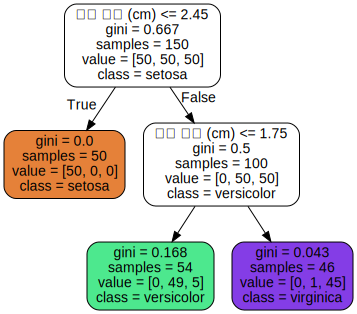

In [10]:
import graphviz

with open("./images/iris_tree.dot", encoding='UTF8') as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='./images', cleanup=True)
dot

지니계수와 엔트로피 계수는 다음과 같다.

#### 지니 계수

$$
G_i = 1 - \sum_{k=1}^{n}{p_{i,k}^{2}}
$$

- $p_{i, k}$ 는 $i$번째 노드에 있는 데이터 중 클래스 $k$에 속한 샘플의 비율이다.
- 예를 들어, level 2의 초록색 노드의 gini 계수는 $1 - (\frac{49}{54})^{2} - (\frac{5}{54})^{2} \approx 0.168$ 이다. 

#### 엔트로피 계수

$$
H_i = - \sum_{\underset{p_{i,k} \neq 0}{k=1}}^{n}{p_{i,k} \log_{2}{\left( p_{i, k} \right)}}
$$

- 예를 들어,  level 2의 초록색 노드의 엔트로피 계수는 $-\frac{49}{54} \log_{2}{\left( \frac{49}{54} \right)} -\frac{5}{54} \log_{2}{\left( \frac{5}{54} \right)} \approx 0.445$ 이다.

#### 둘 중 어느 계수를 사용할까?

지니(Gini)나 엔트로피(Entropy) 계수 둘 다 비슷한 트리를 만든다. 지니 계수가 계산이 조금 더 빠르기 때문에 Scikit-Learn에서는 지니 계수를 기본값을 사용한다. 

하지만, 지니 계수는 가장 빈도가 높은 클래스를 한쪽 가지(branch)로 고립시키는 경향이 있다고 한다.

## 6.7 규제 매개변수

의사결정나무는 학습(또는 훈련) 데이터에 대한 제약이 거의 없기 때문에 학습 데이터에 오버피팅(overfitting, 과대적합)되기 쉽다. 의사결정나무는 모델 파라미터가 없는 것이 나이라 학습 전에 파라미터 개수가 결정되지 않기 때문에, 이러한 모델을 **비파라미터 모델**(nonparametric model)이라 부르기도 한다. 

의사결정나무 모델이 학습 데이터에 과적합 되는 것을 방지하기 위해 몇 가지 규제(regularization)가 있는데, 일반적으로 결정 트리의 **깊이(depth)**를 조절한다. Scikit-Learn에서는 `max_depth` 인자로 트리의 깊이를 설정할 수 있다. 

[`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)에서는 트리의 깊이(`max_depth`) 뿐만 아니라 규제를 하기위한 다른 인자들이 있다. 아래의 매개변수에서 `min_`으로 시작하는 매개변수를 증가 시키거나, `max_`로 시작하는 매개변수를 감소시키면 모델에 규제가 **커진다**.

- `min_samples_split` : 분할되기 위해 노드가 가져야 하는 최소 샘플(데이터) 수
- `min_samples_leaf` : 리프 노드가 가지고 있어야 하는 최소 샘플 수
- `min_weight_fraction_leaf` : `min_samples_leaf`와 같지만 가중치가 부여된 전체 샘플 수에서의 비율
- `max_leaf_nodes` : 리프 노드의 최대 개수
- `max_features` : 각 노드에서 분할에 사용할 특성의 최대 수

아래의 예제는 sklearn의 `moons` 데이터셋에 위의 매개변수 중 `min_samples_leaf`(리프 노드의 최소 샘플 수) 매개변수를 다르게 하여 결정 트리를 학습시킨 것이다.

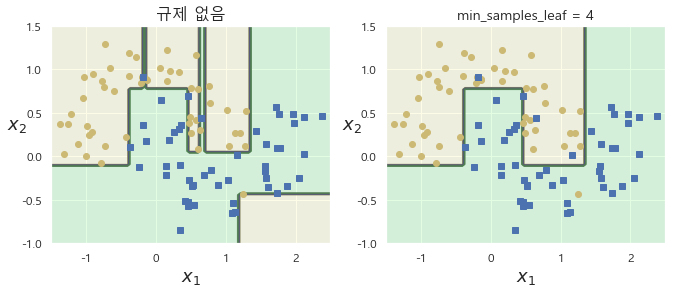

In [13]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("규제 없음", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

### 가지치기(pruning)

**가지치기**(pruning)는 결정트리를 아무런 규제 없이 학습 시킨 뒤 불필요한 노드를 제거하는 방법을 말하며, 마치 나무에서 불필요한 가지를 자르는 것과 같기 때문에 가지치기라 한다.

불순도를 최소화하는 것이 **통계적으로** 효과가 없다면 리프 노드는 필요없는 노드라 할 수 있다. 이렇게 판단하는 기준은 **$\chi^{2}$ 검정**(chi-squared, 카이 제곱검정)을 사용하며, **$p$-value** 값이 $0.05$보다 높으면 해당 노드는 불필요한 노드로 추정하여 해당 노드의 자식 노드를 가지치기 한다.

## 6.8 회귀